In [1]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import model_methods
from model_methods import update_medium, get_base_model, add_sucrose
import numpy as np

import cobra
from cobra.io import read_sbml_model
from cobra import Reaction, Metabolite
from tqdm import tqdm

%matplotlib inline

In [2]:
model = update_medium(get_base_model())

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/cobra/core/model.py:787: UserWarning: SEPHCHCS not in iNF517
  warn(f"{reaction} not in {self}")
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/cobra/core/model.py:787: UserWarning: SHCHCS3 not in iNF517
  warn(f"{reaction} not in {self}")
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/cobra/core/model.py:787: UserWarning: DHNCOAS not in iNF517
  warn(f"{reaction} not in {self}")
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/cobra/core/model.py:787: UserWarning: NPHS_c not in iNF517
  warn(f"{reaction} not in {self}")
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/cobra/core/model.py:787: UserWarning: DHNAOT7 not in iNF517
  warn(f"{reaction} not in {self}")
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/cobra/core/model.py:787: UserWarning: AMMQT7 not in 

**add_dynamic_bounds**: This function updates the bounds of the model's reactions based on the current state y. Specifically, it adjusts the lower bound of the glucose exchange reaction (EX_glc__D_e) based on a formula involving glucose concentration.

In [3]:
def add_dynamic_bounds(model, y):
    biomass, glucose, mqn7 = y
    
    # Calculate the maximum glucose import rate based on a formula
    glucose_max_import = -10 * glucose / (5 + glucose)
    
    # Update the lower bound of the glucose exchange reaction
    model.reactions.EX_glc__D_e.lower_bound = glucose_max_import

**dynamic_system** function defines the dynamic system of ordinary differential equations (ODEs) that describe the time evolution of the system. Inside the function, the model's bounds are adjusted dynamically using add_dynamic_bounds. Linear programming feasibility constraints are added to the model, and lexicographic constraints for specific fluxes are established. The function returns the calculated fluxes based on the lexicographic constraints and the biomass.

In [4]:
def dynamic_system(t, y):
    biomass, glucose, mqn7 = y
    
    # Create a context manager to ensure changes to the model are reverted after the block
    with model:
        # Update dynamic bounds based on the current state
        add_dynamic_bounds(model, y)
        
        # Add linear programming feasibility constraints to the model
        cobra.util.add_lp_feasibility(model)
        
        # Fix the objective as a constraint
        feasibility = cobra.util.fix_objective_as_constraint(model)
        
        # Add lexicographic constraints for fluxes
        lex_constraints = cobra.util.add_lexicographic_constraints(model, 
                                                                   ['BIOMASS_LLA', 'EX_glc__D_e', 'DM_mqn7_c'], 
                                                                   ['max', 'max', 'max'])

    # Calculate fluxes based on the lexicographic constraints and biomass
    fluxes = lex_constraints.values
    fluxes *= biomass
    
    if dynamic_system.pbar is not None:
        dynamic_system.pbar.update(1)
        dynamic_system.pbar.set_description('t = {:.3f}'.format(t))


    return fluxes

dynamic_system.pbar = None

**infeasible_event** function sets up an event that triggers when the system becomes infeasible, based on the feasibility of the linear programming constraints. It prints the feasibility status during the event. The event is terminal, meaning it will stop the integration when triggered.

In [5]:
def infeasible_event(t, y):
    with model:
        # Update dynamic bounds based on the current state
        add_dynamic_bounds(model, y)
        
        # Add linear programming feasibility constraints to the model
        cobra.util.add_lp_feasibility(model)
        
        # Fix the objective as a constraint
        feasibility = cobra.util.fix_objective_as_constraint(model)
        print("Feasibility:", feasibility)

    # Set the event condition based on feasibility
    return feasibility - infeasible_event.epsilon

# Set additional properties for the infeasible event function
infeasible_event.epsilon = 1E-6
infeasible_event.direction = 1
infeasible_event.terminal = True

In the next code chunk, a dynamic flux balance analysis (dFBA) simulation is set up and performed. The ts variable defines the desired time points for integration, ranging from 0 to 4 minutes, with a resolution of 100 time points. Initial concentrations for the system are specified with y0, representing 0.1 g/L biomass, 10 g/L glucose, and 0 g/L mqn7. 

The tqdm library is employed to create a progress bar, enhancing the visualization of the integration progress. 
The solve_ivp function from SciPy is then utilized to numerically integrate the dynamic system of equations (dynamic_system). The integration is conducted over the defined time span, with initial conditions provided by y0. 

The results are stored at the specified time points (t_eval), and the integration uses the BDF (backward differentiation formula) method, suitable for stiff problems. Additionally, an infeasible event (infeasible_event) is employed to detect and handle infeasible states during the simulation.

In [6]:
# Desired integration time points and resolution
ts = np.linspace(0, 4, 100)  # Integration over a time span of 0 to 4 minutes with 100 time points

# Initial concentrations: 0.1 g/L biomass, 10 g/L glucose, 0 g/L mqn7
y0 = [0.1, 10, 0]

# Perform numerical integration using solve_ivp
with tqdm() as pbar:
    dynamic_system.pbar = pbar
    sol = solve_ivp(
        fun=dynamic_system,          # System of differential equations
        events=[infeasible_event],    # Event function to detect infeasibility
        t_span=(ts.min(), ts.max()),  # Time span for integration
        y0=y0,                        # Initial conditions
        t_eval=ts,                    # Time points for which to store the results
        rtol=1e-6,                    # Relative tolerance for integration
        atol=1e-8,                    # Absolute tolerance for integration
        method='BDF'                  # Use the BDF method for stiff problems
        )

t = 0.000: : 8it [00:08,  1.09s/it]

Feasibility: 1.9312489478433323e-17


t = 0.000: : 10it [00:12,  1.31s/it]

Feasibility: 1.9312489478433323e-17


t = 0.001: : 12it [00:15,  1.43s/it]

Feasibility: 1.9312489478433323e-17


t = 0.005: : 14it [00:18,  1.40s/it]

Feasibility: 1.9312489478433323e-17


t = 0.009: : 16it [00:21,  1.43s/it]

Feasibility: 1.9312489478433323e-17


t = 0.037: : 18it [00:24,  1.44s/it]

Feasibility: 1.9312489478433323e-17


t = 0.064: : 20it [00:27,  1.46s/it]

Feasibility: 1.9312489478433323e-17


t = 0.091: : 22it [00:30,  1.41s/it]

Feasibility: 1.9312489478433323e-17


t = 0.193: : 24it [00:33,  1.43s/it]

Feasibility: 1.9312489478433323e-17


t = 0.294: : 26it [00:36,  1.42s/it]

Feasibility: 1.9312489478433323e-17


t = 0.396: : 28it [00:39,  1.45s/it]

Feasibility: 1.9312489478433323e-17


t = 0.729: : 30it [00:42,  1.44s/it]

Feasibility: 1.9312489478433323e-17


t = 1.063: : 32it [00:45,  1.46s/it]

Feasibility: 1.9312489478433323e-17


t = 1.397: : 34it [00:48,  1.42s/it]

Feasibility: 1.9312489478433323e-17


t = 1.730: : 36it [00:52,  1.45s/it]

Feasibility: 1.9312489478433323e-17


t = 2.571: : 38it [00:54,  1.42s/it]

Feasibility: 1.9312489478433323e-17


t = 3.412: : 40it [00:58,  1.48s/it]

Feasibility: 1.9312489478433323e-17


t = 4.000: : 42it [01:01,  1.44s/it]

Feasibility: 1.9312489478433323e-17


t = 4.000: : 42it [01:02,  1.48s/it]


The feasibility is very close to zero, suggesting that the linear programming problem is practically feasible. However, keep in mind that due to numerical precision, a value close to zero may not be exactly zero, and it's often treated as feasible within a certain tolerance level (in this case, 1e-15).

## Biomass and Glucose concentrations relation

The current plot displays Biomass (primary y-axis, blue line) and Glucose (secondary y-axis, red line) over time. The initial concentration of Biomass is 0.1 g/L, and Glucose is 10 g/L. 
The inverse proportion is consistent with the typical behavior observed in microbial growth, as the growth rate is often influenced by the availability of a carbon source, such as glucose.

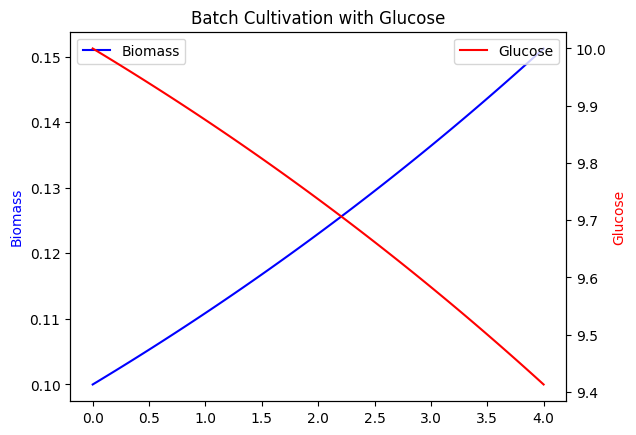

In [7]:
# Create a subplot with a single axis
ax = plt.subplot(111)

# Plot the first variable (Biomass) on the primary y-axis
ax.plot(sol.t, sol.y.T[:, 0], label='Biomass', color='b')

# Create a twin axis sharing the xaxis with the primary axis
ax2 = plt.twinx(ax)

# Plot the second variable (Glucose) on the secondary y-axis in red
ax2.plot(sol.t, sol.y.T[:, 1], label='Glucose', color='r')

# Set y-axis labels for each variable
ax.set_ylabel('Biomass', color='b')
ax2.set_ylabel('Glucose', color='r')

# Display the legend for better interpretation of the plot
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# Set the title of the plot
plt.title('Batch Cultivation with Glucose')

# Display the plot
plt.show()

## Biomass and MQN7 concentrations relation

The second plot depicts Biomass (primary y-axis, blue line) and mqn7 (secondary y-axis, green line) over time. The initial concentration of Biomass is 0.1 g/L, and mqn7 is initially at 0 g/L. Similar to the first plot, Biomass increases over time, and mqn7 also shows a gradual rise, indicating its production within the system. Feasibility checks confirm the system's viability. The decision to create two separate plots was done because of the lines being merged together. 

Three reasons for having biomass and mqn7 concentrations being directly proportional were identified:

<p>
1. <b> mqn7 as a metabolic cofactor </b>: the molecule might act as a cofactor or signaling molecule in metabolic pathways crucial for cell growth. Its presence could enhance or regulate key reactions that contribute to biomass synthesis. For example, it might modulate the activity of enzymes involved in these pathways, influencing the production of essential amino acids
</p>

<p>
2. <b> mqn7 role in the energy metabolism </b> if the production or utilization of mqn7 is linked to energy generation, this could influence the growth rate and biomass accumulation. For example, if the vitamin is involved in the electron transport chain or redox reactions within the cell.
</p>

<p>
3. <b> mqn7 as an intermediate metabolite </b>: mqn7 may serve as an intermediate metabolite in a pathway directly or indirectly linked to biomass production. Its availability or concentration could impact the overall efficiency of biomass synthesis. For example, mqn7 could be involved in the synthesis of precursors for fatty acid. So, it will affect the availability of "building blocks" by being an intermediate molecule.
</p>

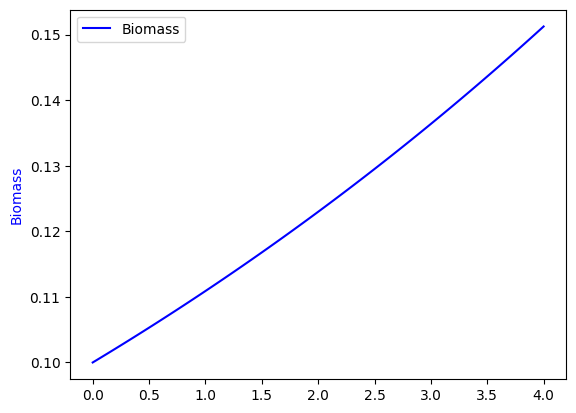

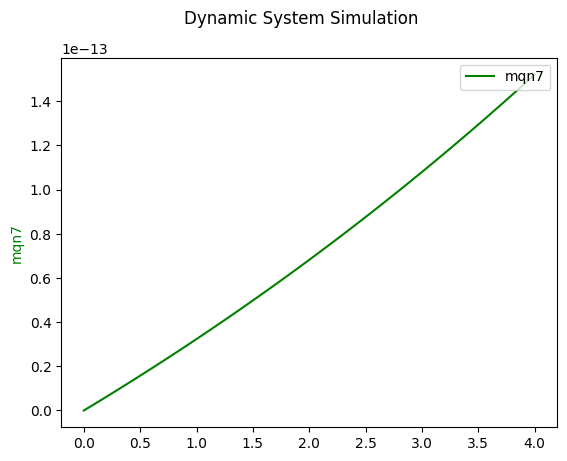

In [8]:
# Create a subplot for Biomass
fig, ax1 = plt.subplots()

# Plot the first variable (Biomass) on the primary y-axis
ax1.plot(sol.t, sol.y.T[:, 0], label='Biomass', color='b')

# Set y-axis label for Biomass
ax1.set_ylabel('Biomass', color='b')

# Display the legend for better interpretation of the plot
ax1.legend(loc='upper left')

# Create a subplot for mqn7
fig, ax2 = plt.subplots()

# Plot the third variable (mqn7) on the primary y-axis in green
ax2.plot(sol.t, sol.y.T[:, 2], label='mqn7', color='g')

# Set y-axis label for mqn7
ax2.set_ylabel('mqn7', color='g')

# Display the legend for better interpretation of the plot
ax2.legend(loc='upper right')

# Set the title of the plot
plt.suptitle('Dynamic System Simulation')

# Display the plots
plt.show()

## Adjusting the functions for the sucrose

In [9]:
model = add_sucrose(model)

def add_dynamic_bounds_sucrose(model, y):
    biomass, sucrose, mqn7 = y  
    sucrose_max_import = -10 * sucrose / (5 + sucrose)
    model.reactions.EX_sucr_e.lower_bound = sucrose_max_import


def dynamic_system_sucrose(t, y):
    biomass, sucrose, mqn7 = y 
    with model:
        add_dynamic_bounds_sucrose(model, y)

        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)
        lex_constraints = cobra.util.add_lexicographic_constraints(
            model, ['BIOMASS_LLA', 'EX_sucr_e', 'DM_mqn7_c'], ['max', 'max', 'max'])

    fluxes = lex_constraints.values
    fluxes *= biomass

    if dynamic_system_sucrose.pbar is not None:
        dynamic_system_sucrose.pbar.update(1)
        dynamic_system_sucrose.pbar.set_description('t = {:.3f}'.format(t))

    return fluxes

dynamic_system_sucrose.pbar = None


def infeasible_event_sucrose(t, y):

    with model:

        add_dynamic_bounds_sucrose(model, y)

        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)
        print("Feasibility:", feasibility)

    return feasibility - infeasible_event_sucrose.epsilon

infeasible_event_sucrose.epsilon = 1E-6
infeasible_event_sucrose.direction = 1
infeasible_event_sucrose.terminal = True

In [10]:
ts = np.linspace(0, 4, 100)  # Integration over a time span of 0 to 4 minutes with 100 time points

# Initial concentrations: 0.1 g/L biomass, 10 g/L glucose, 0 g/L mqn7
y0 = [0.1, 10, 0]

# Perform numerical integration using solve_ivp
with tqdm() as pbar:
    dynamic_system.pbar = pbar
    sol = solve_ivp(
        fun=dynamic_system,          # System of differential equations
        events=[infeasible_event],    # Event function to detect infeasibility
        t_span=(ts.min(), ts.max()),  # Time span for integration
        y0=y0,                        # Initial conditions
        t_eval=ts,                    # Time points for which to store the results
        rtol=1e-6,                    # Relative tolerance for integration
        atol=1e-8,                    # Absolute tolerance for integration
        method='BDF'                  # Use the BDF method for stiff problems
        )

t = 0.000: : 8it [00:08,  1.01s/it]

Feasibility: -1.8368608763010705e-15


t = 0.000: : 10it [00:11,  1.22s/it]

Feasibility: -1.8368608763010705e-15


t = 0.000: : 12it [00:14,  1.39s/it]

Feasibility: -1.8368608763010705e-15


t = 0.000: : 14it [00:17,  1.39s/it]

Feasibility: -1.8368608763010705e-15


t = 0.000: : 16it [00:20,  1.41s/it]

Feasibility: -1.8368608763010705e-15


t = 0.001: : 18it [00:23,  1.49s/it]

Feasibility: -1.8368608763010705e-15


t = 0.002: : 20it [00:26,  1.44s/it]

Feasibility: -1.8368608763010705e-15


t = 0.003: : 22it [00:29,  1.42s/it]

Feasibility: -1.8368608763010705e-15


t = 0.006: : 24it [00:33,  1.53s/it]

Feasibility: -1.8368608763010705e-15


t = 0.010: : 26it [00:36,  1.46s/it]

Feasibility: -1.8368608763010705e-15


t = 0.013: : 28it [00:39,  1.43s/it]

Feasibility: -1.8368608763010705e-15


t = 0.032: : 30it [00:42,  1.41s/it]

Feasibility: -1.8368608763010705e-15


t = 0.050: : 32it [00:45,  1.51s/it]

Feasibility: -1.8368608763010705e-15


t = 0.069: : 34it [00:48,  1.45s/it]

Feasibility: -1.8368608763010705e-15


t = 0.119: : 36it [00:51,  1.42s/it]

Feasibility: -1.8368608763010705e-15


t = 0.169: : 38it [00:54,  1.40s/it]

Feasibility: -1.8368608763010705e-15


t = 0.220: : 40it [00:58,  1.58s/it]

Feasibility: -1.8368608763010705e-15


t = 0.270: : 42it [01:00,  1.49s/it]

Feasibility: -1.8368608763010705e-15


t = 0.515: : 44it [01:03,  1.45s/it]

Feasibility: -1.8368608763010705e-15


t = 0.760: : 46it [01:07,  1.47s/it]

Feasibility: -1.8368608763010705e-15


t = 1.005: : 48it [01:10,  1.53s/it]

Feasibility: -1.8368608763010705e-15


t = 1.251: : 50it [01:15,  1.83s/it]

Feasibility: -1.8368608763010705e-15


t = 1.648: : 52it [01:18,  1.64s/it]

Feasibility: -1.8368608763010705e-15


t = 2.045: : 54it [01:21,  1.53s/it]

Feasibility: -1.8368608763010705e-15


t = 2.442: : 56it [01:24,  1.49s/it]

Feasibility: -1.8368608763010705e-15


t = 2.839: : 58it [01:27,  1.49s/it]

Feasibility: -1.8368608763010705e-15


t = 3.236: : 60it [01:31,  1.71s/it]

Feasibility: -1.8368608763010705e-15


t = 3.942: : 62it [01:34,  1.63s/it]

Feasibility: -1.8368608763010705e-15


t = 4.000: : 64it [01:38,  1.56s/it]

Feasibility: -1.8368608763010705e-15


t = 4.000: : 64it [01:39,  1.55s/it]


Text(0, 0.5, 'Sucrose')

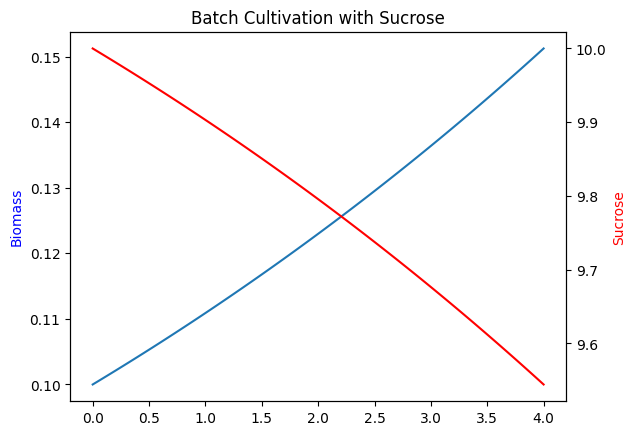

In [11]:
ax = plt.subplot(111)
ax.plot(sol.t, sol.y.T[:, 0])
ax2 = plt.twinx(ax)
ax2.plot(sol.t, sol.y.T[:, 1], color='r')

plt.title('Batch Cultivation with Sucrose')
ax.set_ylabel('Biomass', color='b')
ax2.set_ylabel('Sucrose', color='r')

Text(0, 0.5, 'Sucrose')

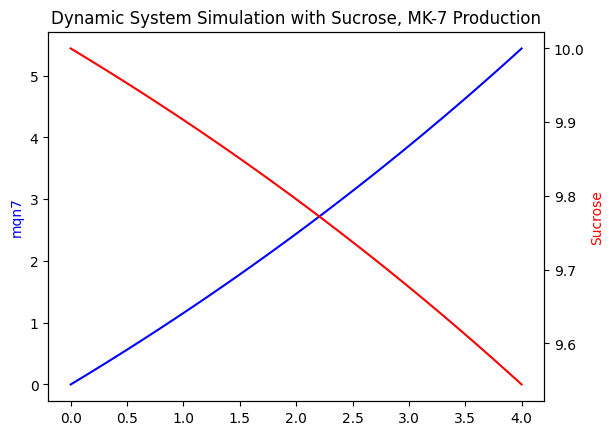

In [12]:
ax = plt.subplot(111)
ax.plot(sol.t, sol.y.T[:, 2], color='b')

ax2 = plt.twinx(ax)
ax2.plot(sol.t, sol.y.T[:, 1], color='r')

plt.title('Dynamic System Simulation with Sucrose, MK-7 Production')
ax.set_ylabel('mqn7', color='b')
ax2.set_ylabel('Sucrose', color='r')